In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [2]:
df_abbrev = pd.read_csv('data/WA-clean-abbrev.csv')

In [3]:
df_abbrev.columns

Index(['Unnamed: 0', 'id', 'state', 'stop_date', 'stop_time', 'location_raw',
       'county_name', 'county_fips', 'fine_grained_location',
       'police_department', 'driver_gender', 'driver_age_raw', 'driver_age',
       'driver_race_raw', 'driver_race', 'violation_raw', 'violation',
       'search_conducted', 'search_type_raw', 'search_type',
       'contraband_found', 'stop_outcome', 'is_arrested', 'violations',
       'officer_id', 'officer_gender', 'officer_race', 'highway_type',
       'road_number', 'milepost', 'lat', 'lon', 'contact_type', 'enforcements',
       'drugs_related_stop'],
      dtype='object')

In [4]:
df = df_abbrev.drop(columns=['state', 'stop_time', 'location_raw', 'county_fips', 'police_department', 'driver_age_raw', 'driver_race_raw',
                         'violation_raw','search_type_raw', 'is_arrested'])

In [5]:
df.head()

,Unnamed: 0,id,stop_date,county_name,fine_grained_location,driver_gender,driver_age,driver_race,violation,search_conducted,...,officer_gender,officer_race,highway_type,road_number,milepost,lat,lon,contact_type,enforcements,drugs_related_stop
0,0,WA-2009-0000001,2009-01-01,Spokane County,S-002-280,M,27.0,White,Equipment,False,...,M,White,S,002,280.0,47.643152,-117.544585,Self-Initiated Contact,3,False
1,1,WA-2009-0000002,2009-01-01,NaN,C-018-NA,M,21.0,White,Speeding,False,...,F,White,C,018,NaN,NaN,NaN,Self-Initiated Contact,3,False
2,2,WA-2009-0000003,2009-01-01,King County,S-516-7,F,17.0,White,Speeding,False,...,M,White,S,516,7.0,47.373378,-122.209356,Self-Initiated Contact,3,False
3,3,WA-2009-0000004,2009-01-01,King County,S-515-2,M,31.0,Asian,"License,Lights,Paperwork",True,...,M,White,S,515,2.0,47.414073,-122.197144,Self-Initiated Contact,"1,1,1",False
4,4,WA-2009-0000005,2009-01-01,Kitsap County,S-303-8,F,24.0,White,Safe movement,False,...,M,White,S,303,8.0,47.659471,-122.675907,Self-Initiated Contact,"3,3",False


In [6]:
df['stop_date'] = pd.to_datetime(df.stop_date)

In [7]:
df.driver_age.fillna(df.driver_age.mean(), inplace=True)

In [8]:
df = df.dropna(subset=['driver_race', 'driver_gender'])

In [9]:
df.isnull().sum() #no missing values for search_conducted - could be interesting to look for

Unnamed: 0                   0
id                           0
stop_date                    0
county_name              10427
fine_grained_location        0
driver_gender                0
driver_age                   0
driver_race                  0
violation                  949
search_conducted             0
search_type              67276
contraband_found             0
stop_outcome               998
violations                 949
officer_id                   0
officer_gender               0
officer_race                 0
highway_type                 0
road_number                  0
milepost                  7648
lat                      10427
lon                      10427
contact_type               550
enforcements               998
drugs_related_stop           0
dtype: int64

In [10]:
df['driver_gender'] = pd.Series(np.where(df.driver_gender.values == 'F', 1, 0),
          df.index)

In [11]:
df['officer_gender'] = pd.Series(np.where(df.officer_gender.values == 'F', 1, 0),
          df.index)

In [12]:
race_dummies = pd.get_dummies(df.driver_race)

In [13]:
race_dummies.head()

,Asian,Black,Hispanic,Other,White
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,0,1


In [14]:
officer_race = pd.get_dummies(df.officer_race)
officer_race.columns = ['O_Asian', 'O_Black', 'O_Hispanic', 'O_Other', 'O_White']
officer_race.head()

,O_Asian,O_Black,O_Hispanic,O_Other,O_White
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [15]:
merged = df.merge(race_dummies, left_index=True, right_index=True)

In [16]:
merged = merged.merge(officer_race, left_index=True, right_index=True)

In [17]:
merged.set_index(merged['stop_date'], inplace=True)

In [18]:
merged['drugs_related_stop'] = pd.Series(np.where(merged.drugs_related_stop.values == False, 0, 1),
          merged.index)


In [19]:
merged['search_conducted'] = pd.Series(np.where(merged.search_conducted.values == False, 0, 1),
          merged.index)

In [20]:
merged['White_White'] = merged.White * merged.O_White

In [21]:
merged['Black_White'] = merged.Black * merged.O_White

In [22]:
merged['Asian_White'] = merged.Asian * merged.O_White

In [23]:
merged['Hispanic_White'] = merged.Hispanic * merged.O_White

In [24]:
merged['White_Black'] = merged.White * merged.O_Black

In [25]:
merged['Black_Black'] = merged.Black * merged.O_Black

In [26]:
merged.head()

,Unnamed: 0,id,stop_date,county_name,fine_grained_location,driver_gender,driver_age,driver_race,violation,search_conducted,...,O_Black,O_Hispanic,O_Other,O_White,White_White,Black_White,Asian_White,Hispanic_White,White_Black,Black_Black
stop_date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,0,WA-2009-0000001,2009-01-01,Spokane County,S-002-280,0,27.0,White,Equipment,0,...,0,0,0,1,1,0,0,0,0,0
2009-01-01,1,WA-2009-0000002,2009-01-01,NaN,C-018-NA,0,21.0,White,Speeding,0,...,0,0,0,1,1,0,0,0,0,0
2009-01-01,2,WA-2009-0000003,2009-01-01,King County,S-516-7,1,17.0,White,Speeding,0,...,0,0,0,1,1,0,0,0,0,0
2009-01-01,3,WA-2009-0000004,2009-01-01,King County,S-515-2,0,31.0,Asian,"License,Lights,Paperwork",1,...,0,0,0,1,0,0,1,0,0,0
2009-01-01,4,WA-2009-0000005,2009-01-01,Kitsap County,S-303-8,1,24.0,White,Safe movement,0,...,0,0,0,1,1,0,0,0,0,0


In [27]:
merged.columns

Index(['Unnamed: 0', 'id', 'stop_date', 'county_name', 'fine_grained_location',
       'driver_gender', 'driver_age', 'driver_race', 'violation',
       'search_conducted', 'search_type', 'contraband_found', 'stop_outcome',
       'violations', 'officer_id', 'officer_gender', 'officer_race',
       'highway_type', 'road_number', 'milepost', 'lat', 'lon', 'contact_type',
       'enforcements', 'drugs_related_stop', 'Asian', 'Black', 'Hispanic',
       'Other', 'White', 'O_Asian', 'O_Black', 'O_Hispanic', 'O_Other',
       'O_White', 'White_White', 'Black_White', 'Asian_White',
       'Hispanic_White', 'White_Black', 'Black_Black'],
      dtype='object')

In [28]:
X = merged.loc[:, ['driver_gender', 'driver_age', 'officer_gender', 'drugs_related_stop', 'Asian', 'Black', 'Hispanic',
       'Other', 'White', 'O_Asian', 'O_Black', 'O_Hispanic', 'O_Other',
       'O_White', 'White_White', 'Black_White', 'Asian_White',
       'Hispanic_White', 'White_Black', 'Black_Black']]

In [192]:
poly = PolynomialFeatures(interaction_only=True)

In [199]:
fitted_X = poly.fit_transform(X)

In [206]:
fitted_X_train, fitted_X_test, fitted_y_train, fitted_y_test = train_test_split(fitted_X, y)

In [207]:
log_model_2 = LogisticRegression()

In [208]:
log_model_2.fit(fitted_X_train, fitted_y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [209]:
preds = log_model_2.predict_proba(fitted_X_test)

In [210]:
log_loss(fitted_y_test, preds)

0.1626029927579093

In [211]:
log_model_2.coef_

array([[-7.49774688e-01, -5.70197317e-01, -1.96049999e-02,
        -2.59176954e-01,  2.89747342e+00, -2.68816096e-01,
         1.47858159e-03,  1.47626383e-03,  2.27831439e-01,
        -7.11744876e-01, -4.44107680e-03, -6.47407715e-01,
         1.89162343e-01, -3.56332505e-01,  6.92442655e-02,
         8.57533436e-03,  2.08096247e-01,  6.53048585e-01,
         3.33546330e-02, -4.66344692e-01, -6.28854512e-01,
         3.23659674e-01,  1.67987580e-01, -2.66115483e-01,
         2.49051304e-01, -2.33712646e-01, -1.37925349e-01,
        -1.81495142e-01,  7.40706504e-03,  1.10235518e-02,
        -1.27812049e-02, -1.28547950e-04, -7.40028376e-03,
         3.79688721e-03, -3.09185038e-03, -1.20665827e-02,
         1.05292331e-02, -1.21074280e-02,  1.88143187e-03,
        -7.84165434e-03, -8.97052204e-01,  9.07335227e-02,
        -4.65946225e-01,  4.83297558e-01, -3.42992818e-01,
        -2.42689905e-02, -5.54645209e-01,  0.00000000e+00,
        -3.64307960e-01,  7.72122819e-01, -1.12346604e-0

In [ ]:
#X = dmatrix("driver_gender + driver_age + officer_gender + drugs_related_stop + Asian +  Black + Hispanic + White + O_Asian+  O_Black+ O_Hispanic+O_White", merged)


#### Feature Engineering and dropping collinear columns

In [29]:
X = X.drop(columns = ['Other', 'O_Other'])

In [30]:
y = merged.loc[:, ['search_conducted']]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [32]:
logistic_model = LogisticRegression()

In [33]:
logistic_model.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
preds = logistic_model.predict_proba(X_test)

In [35]:
pos_preds = preds[:,1]

#### This is the accuracy score, but most of the time a search is not conducted, so this is really not a good metric for evaluating the model.

In [36]:
logistic_model.score(X_test, y_test) 

0.9611145650822359

In [37]:
pos_preds

array([0.01975005, 0.05530369, 0.04794319, ..., 0.02553702, 0.06137876,
       0.03919395])

In [38]:
y_test.sum() #number of searches conducted total

search_conducted    847
dtype: int64

In [39]:
log_loss(y_test, pos_preds)

0.15844391105975347

Being female is negatively associated with getting searched.  Also, the largest postivie coefficient was whether it was a drug-related stop or not.  Asian officers also tend to be associated with a higher likelihood of getting searched.

In [40]:
logistic_model.coef_

array([[-0.39352407, -0.02612597, -0.18398255,  5.34402331, -0.89708827,
        -0.42005079, -0.33117288, -1.08016872,  0.09729142,  0.24368223,
         0.24624028,  0.66388789, -0.42025884, -0.35444857, -0.69681934,
        -0.73128502, -0.64757901,  0.05709114]])

In [41]:
X.columns

Index(['driver_gender', 'driver_age', 'officer_gender', 'drugs_related_stop',
       'Asian', 'Black', 'Hispanic', 'White', 'O_Asian', 'O_Black',
       'O_Hispanic', 'O_White', 'White_White', 'Black_White', 'Asian_White',
       'Hispanic_White', 'White_Black', 'Black_Black'],
      dtype='object')

In [59]:
list(zip(X.columns, logistic_model.coef_[0]))

[('driver_gender', -0.3935240677185543),
 ('driver_age', -0.026125974607706486),
 ('officer_gender', -0.18398255317748974),
 ('drugs_related_stop', 5.344023308753422),
 ('Asian', -0.897088274439007),
 ('Black', -0.4200507938800719),
 ('Hispanic', -0.33117288482073703),
 ('White', -1.0801687160251703),
 ('O_Asian', 0.09729142178973262),
 ('O_Black', 0.24368222941758863),
 ('O_Hispanic', 0.24624028011210103),
 ('O_White', 0.6638878949044615),
 ('White_White', -0.42025884032732197),
 ('Black_White', -0.35444857105573435),
 ('Asian_White', -0.6968193355182569),
 ('Hispanic_White', -0.7312850205495123),
 ('White_Black', -0.6475790081350615),
 ('Black_Black', 0.05709114369361723)]

In [42]:
#looking at some comparisons between race and getting searched

In [43]:
plot_df = merged.loc[:, ['driver_gender', 'driver_age', 'officer_gender', 'search_conducted', 'drugs_related_stop', 'Asian', 'Black', 'Hispanic',
       'Other', 'White', 'O_Asian', 'O_Black', 'O_Hispanic', 'O_Other',
       'O_White', 'White_White', 'Black_White', 'Asian_White',
       'Hispanic_White', 'White_Black', 'Black_Black']]

In [44]:
plot_df_white = plot_df[plot_df.White == 1]
searches = plot_df_white.search_conducted.sum()/len(plot_df_white)
searches

0.043646671479127416

In [45]:
plot_df_black = plot_df[plot_df.Black ==1]
searches_black = plot_df_black.search_conducted.sum()/len(plot_df_black)
searches_black

0.08688881968234195

In [55]:
races =[ 'Asian', 'Black', 'Hispanic',
       'Other', 'White','White_White', 'Black_White', 'Asian_White',
       'Hispanic_White', 'White_Black', 'Black_Black'] 
search_percents = []
for r in races:
    search = plot_df[plot_df[r] == 1]
    search_percents.append(search.search_conducted.sum()/len(search))

In [48]:
search_black_white = plot_df_black[plot_df_black['O_White'] == 1]
search_percents.append(search_black_white.search_conducted.sum()/len(plot_df_black))

In [50]:
search_black_black = plot_df_black[plot_df_black['O_Black'] == 1]
search_percents.append(search_black_black.search_conducted.sum()/len(plot_df_black))

In [53]:
black_searches = plot_df[plot_df['O_Black'] == 1]
black_searches.search_conducted.sum()/len(black_searches)

0.03013278855975485

In [54]:
white_searches = plot_df[plot_df['O_White'] == 1]
white_searches.search_conducted.sum()/len(white_searches)

0.05055608516047029

In [57]:
list(zip(search_percents, races))

[(0.03859280651089525, 'Asian'),
 (0.08688881968234195, 'Black'),
 (0.07350032959789057, 'Hispanic'),
 (0.1615819209039548, 'Other'),
 (0.043646671479127416, 'White'),
 (0.04485092444602301, 'White_White'),
 (0.08972030512168544, 'Black_White'),
 (0.03932244404113733, 'Asian_White'),
 (0.07354028085735403, 'Hispanic_White'),
 (0.022742040285899934, 'White_Black'),
 (0.06569343065693431, 'Black_Black')]

#### Black Cops are more likely to search black people instead of white

Text(0.5,1,'Probability of Getting Searched')

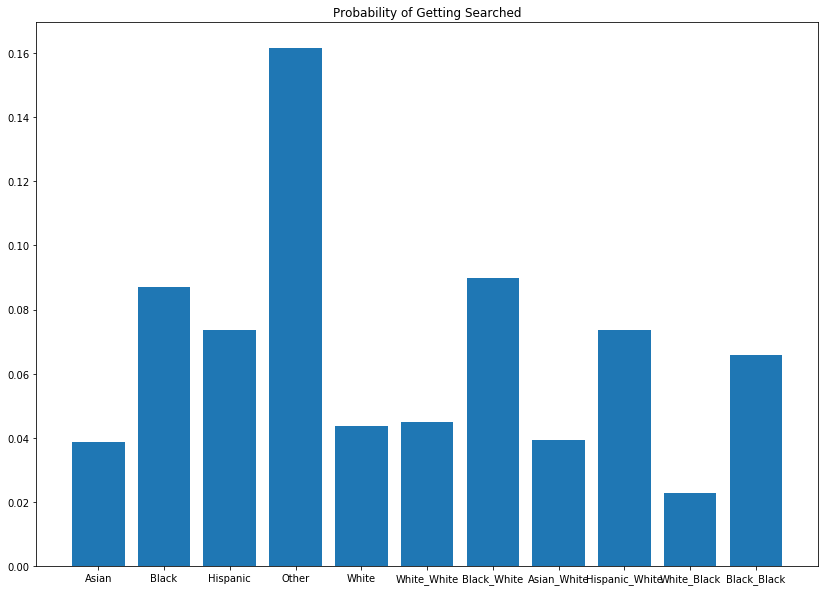

In [267]:
fig, ax = plt.subplots(figsize=(14,10))
ax.bar(races,search_percents)
ax.set_title("Probability of Getting Searched")

In [137]:
y_train.shape

(53077, 1)

In [142]:

# Train and fit random forest model                                                   
rf = RandomForestClassifier(n_estimators=1000,
                           max_depth = 10,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict_proba(X_test)
print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


log loss = 0.16169086437802055
accuracy = 0.9604363307522749


In [149]:
#feature importances
importances = np.argsort(rf.feature_importances_)
rf.feature_importances_

array([0.01180021, 0.12895476, 0.00536186, 0.81259438, 0.00727561,
       0.00299537, 0.00632104, 0.00833695, 0.00302574, 0.0020524 ,
       0.00338669, 0.00307817, 0.00294119, 0.00187563])

#### feature importances from highest to lowest

In [151]:
X_train.columns[importances][::-1]

Index(['drugs_related_stop', 'driver_age', 'driver_gender', 'White', 'Asian',
       'Hispanic', 'officer_gender', 'O_Hispanic', 'O_White', 'O_Asian',
       'Black', 'White_White', 'O_Black', 'Black_White'],
      dtype='object')

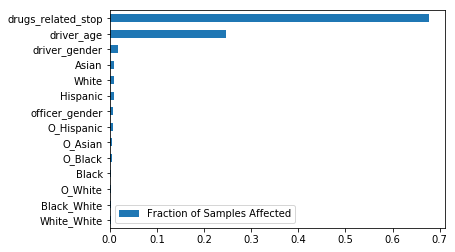

In [158]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh')

In [165]:
from treeinterpreter import treeinterpreter as ti

In [168]:
prediction, bias, contributions = ti.predict(rf, X_test)

In [177]:
bias[1]

array([0.9491754, 0.0508246])

In [185]:
len(contributions)

21231

In [272]:
sum([0.1*x*1.25*(1-0.1)**(x-1) for x in range(1,1000)])

12.500000000000004